In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import string
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample


[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [2]:
# Step 2: Load Dataset
df = pd.read_csv('../data/Reviews.csv')
#df = df[['Text', 'Score']].dropna().sample(100000, random_state=42)
df = df[['Text', 'Score']]
df.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [3]:
len(df)

568454

In [4]:
# Step 3: Create Sentiment Labels
def label_sentiment(score):
    if score <= 2:
        return 'Negative'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Positive'

df['Sentiment'] = df['Score'].apply(label_sentiment)
df['Sentiment'].value_counts()

Sentiment
Positive    443777
Negative     82037
Neutral      42640
Name: count, dtype: int64

In [5]:
# Step 4: Clean the Text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered)

df['Cleaned_Text'] = df['Text'].apply(clean_text)
df[['Text', 'Cleaned_Text', 'Sentiment']].head()

,Text,Cleaned_Text,Sentiment
0,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,Positive
1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanutsth...,Negative
2,This is a confection that has been around a fe...,confection around centuries light pillowy citr...,Positive
3,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,Negative
4,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,Positive


In [6]:
# Step 5: Split Data
X = df['Cleaned_Text']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# Step 6: Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

In [8]:
# Step 7: Model Training
model = LogisticRegression()
model.fit(X_train_vec, y_train)

f:\sentiment_analysis_food_review\Sentiment_Analysis_Project\venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

              precision    recall  f1-score   support

    Negative       0.73      0.67      0.70     16181
     Neutral       0.51      0.19      0.27      8485
    Positive       0.90      0.97      0.93     89025

    accuracy                           0.87    113691
   macro avg       0.71      0.61      0.63    113691
weighted avg       0.85      0.87      0.85    113691



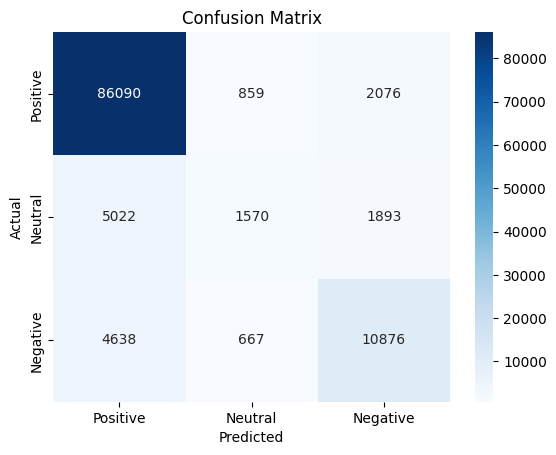

In [9]:
# Step 8: Evaluation
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=['Positive', 'Neutral', 'Negative'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [10]:
from sklearn.svm import LinearSVC

model = LinearSVC(class_weight='balanced')
model.fit(X_train_vec, y_train)
sv_predict = model.predict(X_test_vec)
print("SVC Performance")
print(classification_report(y_test, sv_predict)) 

SVC Performance
              precision    recall  f1-score   support

    Negative       0.67      0.74      0.71     16181
     Neutral       0.37      0.41      0.39      8485
    Positive       0.94      0.91      0.92     89025

    accuracy                           0.85    113691
   macro avg       0.66      0.69      0.67    113691
weighted avg       0.86      0.85      0.85    113691



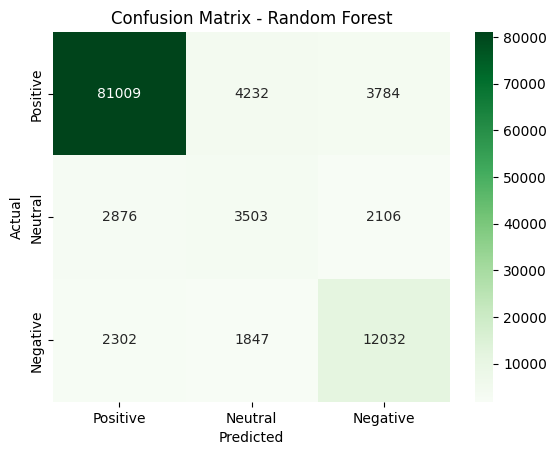

In [12]:
# Step 9: Confusion Matrix for Random Forest
conf_matrix = confusion_matrix(y_test, sv_predict, labels=['Positive', 'Neutral', 'Negative'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [13]:
# Step 9: Save Model and Vectorizer
joblib.dump(model, '../model/model.pkl')
joblib.dump(tfidf, '../model/tfidf_vectorizer.pkl')
print("Model and vectorizer saved.")

Model and vectorizer saved.
